In [1]:
# Cell 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from backend.config_loader import load_config
from backend.utils import *
from pymanticore.analysis.matplotlib import get_mplstyle_path, ManticoreColors

In [2]:
# Cell 2: Configuration Loading
config = load_config()

print("Configuration loaded:")
print(f"Base directory: {config.global_config.basedir}")
print(f"Output directory: {config.global_config.output_dir}")
print(f"Observer coordinates: {config.global_config.observer_coords}")
print(f"Mode1 - eps: {config.mode1.eps}, min_samples: {config.mode1.min_samples}")
print(f"Mode2 - target_snapshot: {config.mode2.target_snapshot}, min_cluster_size: {config.mode2.min_cluster_size}")

mnras_style = "mnras"

Configuration loaded:
Base directory: /cosma7/data/dp004/rttw52/manticore_data/production_runs/v2b/resimulations/2MPP_MULTIBIN_N256_DES_V2/R1024
Output directory: output
Observer coordinates: [500.0, 500.0, 500.0]
Mode1 - eps: 1.75, min_samples: 9
Mode2 - target_snapshot: 10, min_cluster_size: 40


# Load haloes

In [3]:
eps = 1.75
min_samples = 9

# Convert eps to filename format (2.5 -> "2p5")
eps_str = str(eps).replace('.', 'p')
filename = f"clusters_eps_{eps_str}_min_samples_{min_samples}.h5"

clusters, cluster_metadata = load_clusters_from_hdf5(config.global_config.output_dir, filename=filename,
                                                    minimal=False)
print(f"Successfully loaded {len(clusters)} clusters")
clusters_available = True

# Check for traces file existence without loading data
trace_filename = f"halo_traces_eps_{eps_str}_min_samples_{min_samples}.h5"

try:
    trace_filepath = os.path.join(config.global_config.output_dir, trace_filename)
    if os.path.exists(trace_filepath):
        print("Halo trace file found")
        traces_available = True
    else:
        print("No halo trace data found. Run Mode 2 for temporal evolution plots.")
        traces_available = False
except Exception:
    print("No halo trace data found. Run Mode 2 for temporal evolution plots.")
    traces_available = False

Successfully loaded 656 clusters
Halo trace file found


In [4]:
# Cell 4: Data Summary Statistics
if clusters_available:
    cluster_sizes = [c['cluster_size'] for c in clusters]
    
    print("Cluster Statistics:")
    print(f"  Total clusters: {len(clusters)}")
    print(f"  Largest cluster size: {max(cluster_sizes) if cluster_sizes else 0}")
    print(f"  Mean cluster size: {np.mean(cluster_sizes):.2f}")
    print(f"  Median cluster size: {np.median(cluster_sizes):.2f}")
    
    print(f"\nTop 5 clusters by size:")
    sorted_clusters = sorted(clusters, key=lambda x: x['cluster_size'], reverse=True)
    for i, cluster in enumerate(sorted_clusters[:5]):
        print(f"  {i+1}. Cluster {cluster['cluster_id']}: {cluster['cluster_size']} members, "
              f"mass={cluster['mean_m200_mass']:.2e}")

if traces_available:
    cluster_trace_counts = get_cluster_trace_info(config.global_config.output_dir, filename=trace_filename)
    total_traced_haloes = sum(cluster_trace_counts.values())
    
    print(f"\nTrace Statistics:")
    print(f"  Total traced haloes: {total_traced_haloes}")
    print(f"  Clusters with traces: {len(cluster_trace_counts)}")

Cluster Statistics:
  Total clusters: 656
  Largest cluster size: 80
  Mean cluster size: 30.64
  Median cluster size: 22.00

Top 5 clusters by size:
  1. Cluster 106: 80 members, mass=3.24e+14
  2. Cluster 128: 80 members, mass=3.22e+14
  3. Cluster 168: 80 members, mass=1.27e+15
  4. Cluster 40: 80 members, mass=7.69e+14
  5. Cluster 82: 80 members, mass=1.16e+15

Trace Statistics:
  Total traced haloes: 13423
  Clusters with traces: 225


# Cluster sizes

## Cluster sizes from constrained region

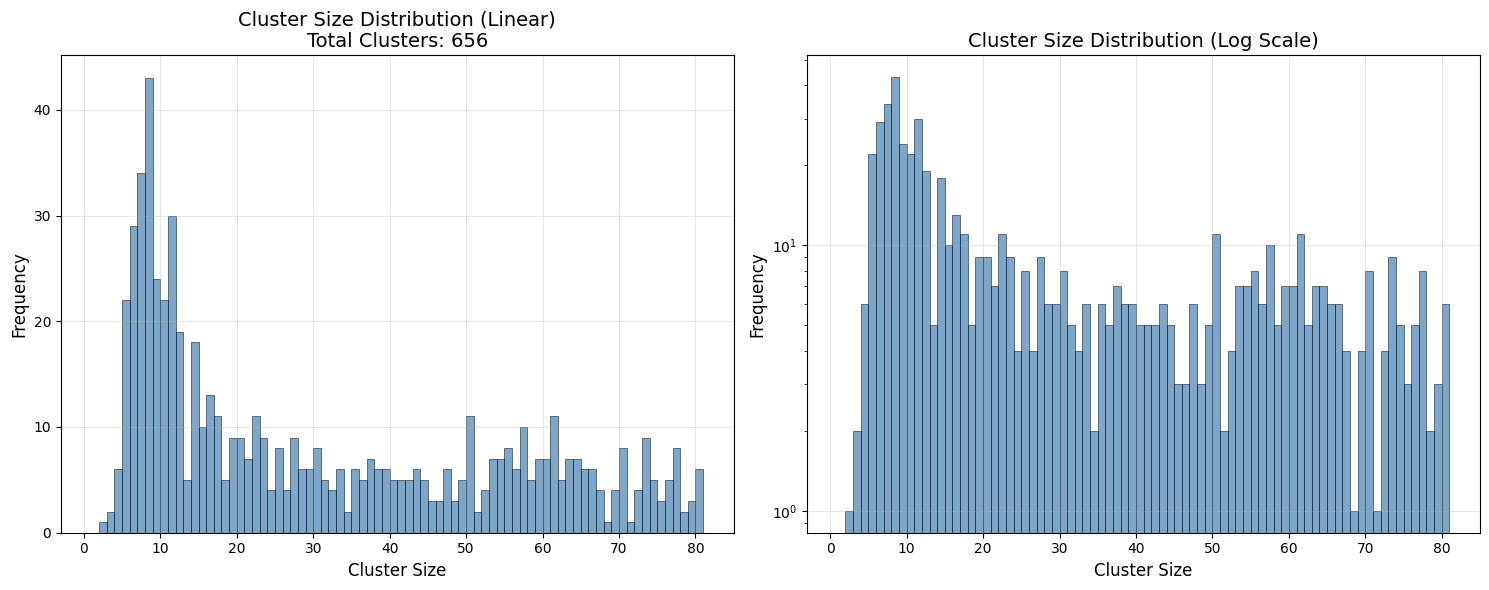

Cluster size statistics:
  Total clusters: 656
  Mean size: 30.64
  Median size: 22.00
  Min size: 2
  Max size: 80
  Standard deviation: 23.32


In [5]:
# Cell: Cluster Size Distribution
if clusters_available and len(clusters) > 0:
    cluster_sizes = [cluster['cluster_size'] for cluster in clusters]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Linear scale histogram
    ax1.hist(cluster_sizes, bins=range(1, max(cluster_sizes) + 2), alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
    ax1.set_xlabel('Cluster Size', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.set_title(f'Cluster Size Distribution (Linear)\nTotal Clusters: {len(clusters)}', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Log scale histogram
    ax2.hist(cluster_sizes, bins=range(1, max(cluster_sizes) + 2), alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
    ax2.set_xlabel('Cluster Size', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title('Cluster Size Distribution (Log Scale)', fontsize=14)
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Cluster size statistics:")
    print(f"  Total clusters: {len(cluster_sizes)}")
    print(f"  Mean size: {np.mean(cluster_sizes):.2f}")
    print(f"  Median size: {np.median(cluster_sizes):.2f}")
    print(f"  Min size: {min(cluster_sizes)}")
    print(f"  Max size: {max(cluster_sizes)}")
    print(f"  Standard deviation: {np.std(cluster_sizes):.2f}")

# Plot cluster locations (overview)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

min_members_plot = 40

if clusters_available:
    with plt.style.context(get_mplstyle_path(mnras_style)):
        significant_clusters = [h for h in clusters if h['cluster_size'] >= min_members_plot]
        if len(significant_clusters) == 0:
            print(f"No clusters found with at least {min_members_plot} members")
        else:
            # ---- FIRST FIGURE: 2D XY and Mollweide projections ----
            fig = plt.figure(figsize=(6.5, 3.15))
            gs = fig.add_gridspec(1, 2, width_ratios=[1, 2])

            ax1 = fig.add_subplot(gs[0, 0])
            ax2 = fig.add_subplot(gs[0, 1], projection='mollweide')

            tab20_colors = plt.cm.tab20(np.linspace(0, 1, 20))
            random.seed(42)
            assigned_colors = random.choices(tab20_colors, k=len(significant_clusters))

            for i, cluster in enumerate(significant_clusters):
                positions = cluster['member_data']['BoundSubhalo/CentreOfMass']
                color = assigned_colors[i]
                ax1.scatter(positions[:, 0], positions[:, 1], c=[color], s=1, alpha=0.7, marker=".")

                # Mollweide expects longitude (ra) in [-pi, pi] and latitude (dec) in radians
                ra = np.asarray(cluster['member_data']['ra'])
                dec = np.asarray(cluster['member_data']['dec'])
                ra_wrapped = np.where(ra > 180, ra - 360, ra)  # wrap to [-180, 180]
                ra_rad = np.radians(ra_wrapped)
                dec_rad = np.radians(dec)
                ax2.scatter(ra_rad, dec_rad, c=[color], s=1, alpha=0.7, marker=".")

            # 2D plot formatting
            ax1.set_xlabel('X (Mpc)')
            ax1.set_ylabel('Y (Mpc)')
            ax1.set_ylim(0,1000)
            ax1.set_xlim(0,1000)
            circle = plt.Circle((500, 500), 300, fill=False, color='black', linestyle='--', linewidth=2)
            ax1.add_patch(circle)
            ax1.set_aspect('equal')

            # Mollweide formatting
            ax2.grid(True, alpha=0.3)
            # Set xticks in radians for Mollweide, with labels in degrees
            tick_labels = np.arange(-150, 181, 30)
            ax2.set_xticks(np.radians(tick_labels))
            ax2.set_xticklabels([f"{tl}°" for tl in tick_labels])
            ax2.set_xlabel('Right Ascension [deg]')
            ax2.set_ylabel('Declination [deg]')

            plt.tight_layout(pad=0.1)
            plt.savefig("./plots/posterior_positions.pdf")
            plt.show()
            
            # ---- SECOND FIGURE: Histogram of Median Distances ----
            significant_median_distances = [
                np.median(cluster['member_data']['dist'])
                for cluster in significant_clusters
            ]
            fig, ax = plt.subplots(figsize=(3.15, 2.5))
            n, bins, patches = ax.hist(significant_median_distances, bins=np.arange(0,510,10),
                                       alpha=0.7, edgecolor='black')
            bin_centers = (bins[:-1] + bins[1:]) / 2
            r_squared_line = bin_centers**2
            scaling_factor = 1./900
            r_squared_line *= scaling_factor
            ax.plot(bin_centers, r_squared_line, 'r--', linewidth=2, label=r'$N \propto R^2$')
            ax.set_xlabel('Median Distance (Mpc)')
            ax.set_ylabel('Number of Clusters')
            ax.set_ylim(0, 1.1 * np.max(n))
            ax.legend()
            plt.tight_layout(pad=0.1)
            plt.savefig("./plots/median_distances.pdf")
            plt.show()


# Helper plot functions

In [5]:
# Cell 6: Cluster Diagnostic Function
def plot_cluster_diagnostic(cluster_id=None, coordinates=None):
   # If coordinates are provided, use them directly
   if coordinates is not None:
       target_cluster_center = np.array(coordinates)
       target_cluster_id = "Custom"
       cluster_type = "Custom"
       target_cluster = {
           'cluster_size': 'N/A',
           'mean_mass': 'N/A',
           'mass_std': 'N/A'
       }
   else:
       # Original cluster-based logic
       if not clusters_available or len(clusters) == 0:
           print("No clusters available for diagnostic plot")
           return
       
       # Find target cluster
       if cluster_id is None:
           target_cluster = max(clusters, key=lambda x: x['cluster_size'])
           cluster_type = "Largest"
       else:
           target_cluster = None
           for cluster in clusters:
               if cluster['cluster_id'] == cluster_id:
                   target_cluster = cluster
                   break
           
           if target_cluster is None:
               print(f"Cluster ID {cluster_id} not found")
               return
           cluster_type = "Selected"
       
       target_cluster_center = target_cluster['mean_position']
       target_cluster_id = target_cluster['cluster_id']
   
   # Get all positions for plotting context
   if coordinates is None:
       all_positions = []
       all_cluster_ids = []
       
       for cluster in clusters:
           positions = cluster['member_data']['BoundSubhalo/CentreOfMass']
           cluster_id_val = cluster['cluster_id']
           all_positions.extend(positions)
           all_cluster_ids.extend([cluster_id_val] * len(positions))
       
       all_positions = np.array(all_positions)
       all_cluster_ids = np.array(all_cluster_ids)
       
       distances = np.linalg.norm(all_positions - target_cluster_center, axis=1)
       within_15mpc = distances <= 15.0
       
       nearby_positions = all_positions[within_15mpc]
       nearby_cluster_labels = all_cluster_ids[within_15mpc]
   else:
       # For custom coordinates, we still need existing cluster data for context
       if not clusters_available or len(clusters) == 0:
           # If no clusters exist, create empty arrays for plotting
           nearby_positions = np.array([]).reshape(0, 3)
           nearby_cluster_labels = np.array([])
       else:
           all_positions = []
           all_cluster_ids = []
           
           for cluster in clusters:
               positions = cluster['member_data']['BoundSubhalo/CentreOfMass']
               cluster_id_val = cluster['cluster_id']
               all_positions.extend(positions)
               all_cluster_ids.extend([cluster_id_val] * len(positions))
           
           all_positions = np.array(all_positions)
           all_cluster_ids = np.array(all_cluster_ids)
           
           distances = np.linalg.norm(all_positions - target_cluster_center, axis=1)
           within_15mpc = distances <= 15.0
           
           nearby_positions = all_positions[within_15mpc]
           nearby_cluster_labels = all_cluster_ids[within_15mpc]
   
   fig, axes = plt.subplots(1, 3, figsize=(18, 6))
   
   if len(nearby_cluster_labels) > 0:
       unique_labels = np.unique(nearby_cluster_labels)
       colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
   else:
       unique_labels = []
       colors = []
   
   projections = [
       (0, 1, 'X', 'Y', 'X-Y'),
       (0, 2, 'X', 'Z', 'X-Z'), 
       (1, 2, 'Y', 'Z', 'Y-Z')
   ]
   
   for ax_idx, (dim1, dim2, label1, label2, proj_name) in enumerate(projections):
       ax = axes[ax_idx]
       
       # Plot existing clusters if any
       for i, label in enumerate(unique_labels):
           mask = nearby_cluster_labels == label
           if coordinates is None and label == target_cluster_id:
               ax.scatter(nearby_positions[mask, dim1], nearby_positions[mask, dim2], 
                         c='gray', s=80, alpha=0.8, label=f'{cluster_type} Cluster (ID {label})', edgecolors='darkred')
           else:
               ax.scatter(nearby_positions[mask, dim1], nearby_positions[mask, dim2], 
                         c=[colors[i]], s=40, alpha=0.6, label=f'Cluster {label}')
       
       # Plot the target center (cluster center or custom coordinates)
       center_label = 'Custom Center' if coordinates is not None else 'Cluster Center'
       ax.scatter(target_cluster_center[dim1], target_cluster_center[dim2], 
                 c='black', s=300, marker='*', label=center_label, edgecolors='white', linewidth=2)
       
       circle = plt.Circle((target_cluster_center[dim1], target_cluster_center[dim2]), 
                          7.5, fill=False, color='black', linestyle='--', linewidth=2, 
                          label='7.5 Mpc (eps threshold)')
       ax.add_patch(circle)
       
       ax.set_xlabel(f'{label1} (Mpc)')
       ax.set_ylabel(f'{label2} (Mpc)')
       ax.set_title(f'{proj_name} projection')
       ax.set_aspect('equal')
       
       if ax_idx == 0:
           ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
   
   if coordinates is not None:
       fig.suptitle(f'Haloes within 15 Mpc of Custom Coordinates\n'
                   f'Center: [{target_cluster_center[0]:.1f}, {target_cluster_center[1]:.1f}, {target_cluster_center[2]:.1f}]', 
                   fontsize=14)
       
       print(f"Custom coordinates analysis:")
       print(f"  Center: [{target_cluster_center[0]:.1f}, {target_cluster_center[1]:.1f}, {target_cluster_center[2]:.1f}]")
   else:
       fig.suptitle(f'Haloes within 15 Mpc of {cluster_type} Cluster\n'
                   f'Cluster Size: {target_cluster["cluster_size"]}, ID: {target_cluster_id}', 
                   fontsize=14)
       
       print(f"{cluster_type} cluster analysis:")
       print(f"  Cluster ID: {target_cluster_id}")
       print(f"  Size: {target_cluster['cluster_size']} members")
       print(f"  Center: [{target_cluster_center[0]:.1f}, {target_cluster_center[1]:.1f}, {target_cluster_center[2]:.1f}]")
       print(f"  Mean m200 mass: {target_cluster['mean_m200_mass']:.2e}")
       print(f"  Mass m200 std: {target_cluster['m200_mass_std']:.2e}")
   
   plt.tight_layout()
   plt.show()

In [6]:
def find_control_matches_and_recenter(cluster_id, mass_tolerance_dex=0.1):
    """
    Find control matches for each halo in a constrained cluster and recenter them.
    Uses index for fast matching.
    """
    # Load constrained cluster traces
    constrained_traces = load_single_cluster_traces(cluster_id, config.global_config.output_dir, filename=trace_filename)
    if constrained_traces is None:
        print(f"No constrained traces found for cluster {cluster_id}")
        return None, None
    
    # Load control index for fast matching
    control_filename = f"control_halo_traces_mass_{config.mode4.m200_mass_cut:.1e}_radius_{config.mode4.radius_cut}.h5"
    control_index = load_halo_traces_index(config.global_config.output_dir, filename=control_filename)
    
    if control_index is None:
        print(f"Could not load control index from {control_filename}")
        return None, None
    
    # Get final masses and positions for constrained haloes
    constrained_final_masses = []
    constrained_final_positions = []
    
    for trace in constrained_traces:
        # Get final snapshot (77) data
        final_idx = np.where(trace['snapshots'] == 77)[0]
        if len(final_idx) > 0:
            final_mass = trace['BoundSubhalo/TotalMass'][final_idx[0]]
            final_pos = trace['BoundSubhalo/CentreOfMass'][final_idx[0]]
            constrained_final_masses.append(final_mass)
            constrained_final_positions.append(final_pos)
    
    constrained_final_positions = np.array(constrained_final_positions)
    constrained_mean_position = np.mean(constrained_final_positions, axis=0)
    
    # Fast matching using index arrays
    control_masses = control_index['final_m200_masses']
    control_positions = control_index['final_positions']
    control_keys = control_index['halo_keys']
    
    matched_control_keys = []
    used_indices = set()
    
    for i, constrained_mass in enumerate(constrained_final_masses):
        best_match_idx = None
        best_mass_diff = float('inf')
        
        log_constrained_mass = np.log10(constrained_mass)
        
        for j, control_mass in enumerate(control_masses):
            if j in used_indices:
                continue
                
            log_control_mass = np.log10(control_mass)
            mass_diff = abs(log_constrained_mass - log_control_mass)
            
            if mass_diff <= mass_tolerance_dex and mass_diff < best_mass_diff:
                best_match_idx = j
                best_mass_diff = mass_diff
        
        if best_match_idx is not None:
            matched_control_keys.append(control_keys[best_match_idx])
            used_indices.add(best_match_idx)
    
    if len(matched_control_keys) == 0:
        print(f"No control matches found for cluster {cluster_id}")
        return constrained_traces, []
    
    # Load only the matched control traces
    matched_control_traces_dict = load_specific_halo_traces(matched_control_keys, config.global_config.output_dir, filename=control_filename)
    
    # Convert to list and recenter
    matched_control_traces = []
    for i, control_key in enumerate(matched_control_keys):
        if control_key in matched_control_traces_dict:
            recentered_trace = matched_control_traces_dict[control_key].copy()
            
            # Get control final position from index
            control_idx = control_keys.index(control_key)
            control_final_pos = control_positions[control_idx]
            
            # Calculate offset for recentering
            offset = constrained_mean_position - control_final_pos
            
            # Apply offset to position arrays
            recentered_trace['BoundSubhalo/CentreOfMass'] = recentered_trace['BoundSubhalo/CentreOfMass'] + offset
            if 'SO/200_crit/CentreOfMass' in recentered_trace:
                recentered_trace['SO/200_crit/CentreOfMass'] = recentered_trace['SO/200_crit/CentreOfMass'] + offset
            
            matched_control_traces.append(recentered_trace)
    
    print(f"Matched {len(matched_control_traces)} out of {len(constrained_final_masses)} constrained haloes")
    
    return constrained_traces, matched_control_traces

In [7]:
# Cell 8a: Single Cluster Trajectory Plot Function
def plot_cluster_trajectory(cluster_id, ax=None):
    traces = load_single_cluster_traces(cluster_id, config.global_config.output_dir, filename=trace_filename)
    
    if traces is None:
        print(f"No traces available for cluster {cluster_id}")
        return None
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(12, 12))
        standalone = True
    else:
        standalone = False
    
    # Calculate cluster centroid from final positions (snapshot 77)
    final_positions = []
    final_masses = []
    for trace_data in traces:
        positions = trace_data['BoundSubhalo/CentreOfMass']
        masses = trace_data['SO/200/crit/TotalMass']
        snapshots = trace_data['snapshots']
        final_idx = np.where(snapshots == 77)[0]
        if len(final_idx) > 0:
            final_positions.append(positions[final_idx[0]])
            final_masses.append(masses[final_idx[0]])
    
    if len(final_positions) > 0:
        final_positions = np.array(final_positions)
        cluster_centroid = np.mean(final_positions, axis=0)
        total_final_mass = np.mean(final_masses)
    else:
        cluster_centroid = np.array([0, 0, 0])
        total_final_mass = 0
    
    # Generate colors for each trajectory
    colors = plt.cm.tab20(np.linspace(0, 1, min(20, len(traces))))
    if len(traces) > 20:
        colors = plt.cm.gist_ncar(np.linspace(0, 1, len(traces)))
    
    for i, trace_data in enumerate(traces):
        positions = trace_data['BoundSubhalo/CentreOfMass']
        snapshots = trace_data['snapshots']
        
        # Plot trajectory line
        ax.plot(positions[:, 0], positions[:, 1], '-', 
               alpha=0.5, linewidth=0.8, color=colors[i])
        
        # Plot start and end points with smaller sizes
        ax.scatter(positions[0, 0], positions[0, 1], 
                  c='red', s=8, marker='s', alpha=0.9, 
                  edgecolors='darkred', linewidth=0.3, zorder=10)
        ax.scatter(positions[-1, 0], positions[-1, 1], 
                  c='blue', s=8, marker='o', alpha=0.9,
                  edgecolors='darkblue', linewidth=0.3, zorder=10)
    
    # Add radial rings at 10 and 20 Mpc
    circle_10 = plt.Circle((cluster_centroid[0], cluster_centroid[1]), 
                          10, fill=False, color='gray', linestyle='--', 
                          linewidth=1, alpha=0.7)
    ax.add_patch(circle_10)
    
    # Set axis limits to +/- 15 Mpc from cluster centroid
    ax.set_xlim(cluster_centroid[0] - 15, cluster_centroid[0] + 15)
    ax.set_ylim(cluster_centroid[1] - 15, cluster_centroid[1] + 15)
    
    # Add text box with cluster information in lower left corner
    info_text = f'Cluster {cluster_id} (n={len(traces)})\n' + r"$\langle M_{\mathrm{200}}$($z=0) \rangle$ =" + f'{total_final_mass:.2e}' + r' M$_{\odot}$'
    ax.text(0.05, 0.05, info_text, transform=ax.transAxes, fontsize=9,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8),
            verticalalignment='bottom')
    
    ax.set_xlabel('X (Mpc)')
    ax.set_ylabel('Y (Mpc)')
    ax.set_aspect('equal')
    ax.set_facecolor('#f8f8f8')
    ax.tick_params(labelsize=8)
    
    if standalone:
        plt.tight_layout()
        plt.show()
    
    return traces

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cluster_mass_evolution(cluster_id, ax=None):
    """
    Plot the median and 10th–90th percentile range of BoundSubhalo/TotalMass
    as a function of snapshot for all haloes in the given cluster.
    
    Parameters
    ----------
    cluster_id : int or str
        Identifier of the cluster to load.
    ax : matplotlib.axes.Axes, optional
        Axes in which to plot. If None, creates a new figure + axes.

    Returns
    -------
    None
    """
    # Load all traces for this cluster
    traces = load_single_cluster_traces(cluster_id, config.global_config.output_dir, filename=trace_filename)
    if traces is None or len(traces) == 0:
        print(f"No traces available for cluster {cluster_id}")
        return

    # Gather all unique snapshot indices present
    all_snaps = np.unique(np.concatenate([t['snapshots'] for t in traces]))
    all_snaps.sort()

    # For each snapshot, collect the masses from each trace (where available)
    medians = []
    p10 = []
    p90 = []

    for snap in all_snaps:
        masses_at_snap = []
        for t in traces:
            # find if this trace has the snapshot
            idx = np.where(t['snapshots'] == snap)[0]
            if idx.size > 0:
                masses_at_snap.append(t['BoundSubhalo/TotalMass'][idx[0]])
        if len(masses_at_snap) > 0:
            arr = np.array(masses_at_snap)
            p10.append(np.percentile(arr, 10))
            medians.append(np.percentile(arr, 50))
            p90.append(np.percentile(arr, 90))
        else:
            # no data for this snapshot
            p10.append(np.nan)
            medians.append(np.nan)
            p90.append(np.nan)

    # Prepare the plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))
        standalone = True
    else:
        standalone = False

    # Convert lists to arrays
    all_snaps = np.array(all_snaps)
    p10 = np.array(p10)
    medians = np.array(medians)
    p90 = np.array(p90)

    # Plot median line
    ax.plot(all_snaps, medians, '-', lw=2, label='Median Mass', color='C0')

    # Shade 10th–90th percentile range
    ax.fill_between(all_snaps, p10, p90, color='C0', alpha=0.3,
                    label='10th–90th percentile')

    # Labels & styling
    ax.set_xlabel('Snapshot', fontsize=12)
    ax.set_ylabel('BoundSubhalo / TotalMass', fontsize=12)
    ax.set_title(f'Cluster {cluster_id}: Mass Evolution (n={len(traces)})', pad=10)
    ax.grid(True, alpha=0.2)
    ax.legend(fontsize=10)
    ax.tick_params(labelsize=10)

    if standalone:
        plt.tight_layout()
        plt.show()


In [9]:
# Cell: Single Cluster Mass Distribution Function
def plot_cluster_mass_distribution(cluster_id, ax=None):
    if not clusters_available:
        print(f"No clusters available")
        return
    
    # Find the cluster
    target_cluster = None
    for cluster in clusters:
        if cluster['cluster_id'] == cluster_id:
            target_cluster = cluster
            break
    
    if target_cluster is None:
        print(f"Cluster ID {cluster_id} not found")
        return
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        standalone = True
    else:
        standalone = False
    
    cluster_masses = target_cluster['member_data']['BoundSubhalo/TotalMass']
    cluster_size = target_cluster['cluster_size']
    median_mass = np.median(cluster_masses)
    mean_mass = target_cluster['mean_m200_mass']
    
    # Plot histogram of masses
    ax.hist(cluster_masses, bins=10**np.arange(13.,16,0.05), alpha=0.7, color='skyblue', edgecolor='black', linewidth=0.5)
    
    # Add vertical lines for mean and median
    ax.axvline(mean_mass, color='red', linestyle='--', linewidth=2, alpha=0.8, label=f'Mean: {mean_mass:.2e}')
    ax.axvline(median_mass, color='orange', linestyle='-', linewidth=2, alpha=0.8, label=f'Median: {median_mass:.2e}')
    
    ax.set_xlabel('M200 Mass (M☉)', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'Cluster {cluster_id} (n={cluster_size})', fontsize=12, pad=10)
    ax.tick_params(labelsize=8)
    ax.grid(True, alpha=0.3, linewidth=0.5)
    ax.set_xscale("log")
    ax.legend(fontsize=8)
    
    if standalone:
        plt.tight_layout()
        plt.show()

# Cluster evolutions

In [10]:
# Cell 7: Temporal Evolution Setup
if traces_available:
    cluster_trace_counts = get_cluster_trace_info(config.global_config.output_dir, filename=trace_filename)
    
    # Filter clusters with sufficient traces
    min_traces_for_plot = 5  # Adjustable parameter
    significant_trace_clusters = {k: v for k, v in cluster_trace_counts.items() 
                                 if v >= min_traces_for_plot}
    
    print(f"Temporal evolution setup:")
    print(f"  Total clusters with traces: {len(cluster_trace_counts)}")
    print(f"  Clusters with >= {min_traces_for_plot} traces: {len(significant_trace_clusters)}")
    
    # Sort by number of traces
    sorted_trace_clusters = sorted(significant_trace_clusters.items(), 
                                  key=lambda x: x[1], reverse=True)
    
    print(f"\nTop clusters by trace count:")
    for cluster_id, trace_count in sorted_trace_clusters[:10]:
        print(f"  Cluster {cluster_id}: {trace_count} traces")

Temporal evolution setup:
  Total clusters with traces: 225
  Clusters with >= 5 traces: 225

Top clusters by trace count:
  Cluster 40: 80 traces
  Cluster 82: 80 traces
  Cluster 93: 80 traces
  Cluster 106: 80 traces
  Cluster 128: 80 traces
  Cluster 168: 80 traces
  Cluster 99: 79 traces
  Cluster 174: 79 traces
  Cluster 193: 79 traces
  Cluster 45: 78 traces


In [ ]:
# Cell 8b: Top 9 Cluster Trajectory Plots (3x3 Grid)
if traces_available and len(significant_trace_clusters) > 0:
    # Plot top 9 clusters in 3x3 grid
    with plt.style.context(get_mplstyle_path(mnras_style)):
        n_clusters_to_plot = min(9, len(sorted_trace_clusters))
        fig, axes = plt.subplots(3, 3, figsize=(6.5, 6.5))
        axes = axes.flatten()
        
        for plot_idx in range(n_clusters_to_plot):
            cluster_id, trace_count = sorted_trace_clusters[plot_idx]
            ax = axes[plot_idx]
            plot_cluster_trajectory(cluster_id, ax=ax)
        
        # Hide unused subplots
        for plot_idx in range(n_clusters_to_plot, 9):
            axes[plot_idx].set_visible(False)

        # Hide axis labels
        for plot_idx in range(n_clusters_to_plot):
            ax = axes[plot_idx]
            if plot_idx not in [6,7,8]:
                ax.set_xlabel("")
            if plot_idx not in [0,3,6]:
                ax.set_ylabel("")
                
        plt.tight_layout(pad=0.1)
        plt.savefig("./plots/cluster_evolutions.pdf")
        plt.show()

[warn] No constrained traces for cluster 0
Skipping cluster 0 - insufficient matches
[warn] No constrained traces for cluster 1
Skipping cluster 1 - insufficient matches
[warn] No constrained traces for cluster 2
Skipping cluster 2 - insufficient matches
[warn] No constrained traces for cluster 7
Skipping cluster 7 - insufficient matches
[warn] No constrained traces for cluster 8
Skipping cluster 8 - insufficient matches
[warn] No constrained traces for cluster 9
Skipping cluster 9 - insufficient matches
[warn] Cluster 12 does not meet minimum match rate threshold of 80.0%
Skipping cluster 12 - insufficient matches
[warn] No constrained traces for cluster 17
Skipping cluster 17 - insufficient matches
[warn] No constrained traces for cluster 19
Skipping cluster 19 - insufficient matches
[warn] No constrained traces for cluster 21
Skipping cluster 21 - insufficient matches
[warn] No constrained traces for cluster 23
Skipping cluster 23 - insufficient matches
[warn] No constrained traces 

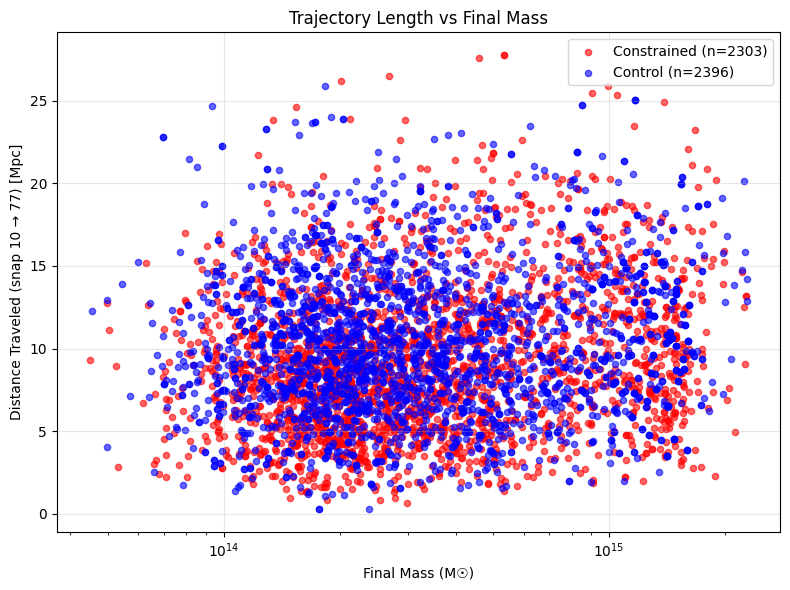

(array([3.09730694e+14, 1.94810489e+14, 2.02073245e+14, ...,
        4.26044817e+14, 2.99753586e+14, 2.83247355e+14]),
 array([4.81464975, 4.37728487, 9.92221263, ..., 8.10000879, 0.66203828,
        8.41470315]),
 array([3.09730694e+14, 2.06805041e+14, 4.26705034e+14, ...,
        4.26081492e+14, 2.99753586e+14, 2.83247355e+14]),
 array([13.05224334, 10.26278793,  5.20365911, ...,  6.76864855,
        12.49131906, 10.6617894 ]))

In [21]:
def plot_trajectory_lengths_vs_mass(cluster_ids, config, trace_filename, 
                                   mass_tolerance_dex=0.1, target_snapshot=10,
                                   min_match_rate=0.8):
    """
    Plot distance traveled (initial to final) vs final mass for constrained and control haloes.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from backend.analysis import find_control_matches_and_recenter_single
    
    # Collect data from multiple clusters
    constrained_distances = []
    constrained_masses = []
    control_distances = []
    control_masses = []
    
    for cluster_id in cluster_ids:
        # Load traces
        constrained_traces, control_traces = find_control_matches_and_recenter_single(
            cluster_id,
            config=config,
            trace_filename=trace_filename,
            mass_tolerance_dex=mass_tolerance_dex,
            min_match_rate=min_match_rate,
        )
        
        if not constrained_traces or not control_traces:
            print(f"Skipping cluster {cluster_id} - insufficient matches")
            continue
        
        # Process constrained traces
        for tr in constrained_traces:
            snaps = tr['snapshots']
            
            # Get initial position (target_snapshot)
            ii = np.where(snaps == target_snapshot)[0]
            if len(ii) == 0:
                continue
            
            # Get final position (snap 77)
            ff = np.where(snaps == 77)[0] 
            if len(ff) == 0:
                continue
            
            # Extract positions and masses
            poskey = 'BoundSubhalo/CentreOfMass' if 'BoundSubhalo/CentreOfMass' in tr else 'SO/200_crit/CentreOfMass'
            masskey = 'BoundSubhalo/TotalMass' if 'BoundSubhalo/TotalMass' in tr else 'SO/200_crit/TotalMass'
            
            if poskey not in tr or masskey not in tr:
                continue
                
            initial_pos = tr[poskey][ii[0]]
            final_pos = tr[poskey][ff[0]]
            final_mass = tr[masskey][ff[0]]
            
            # Calculate distance traveled
            distance = np.linalg.norm(final_pos - initial_pos)
            
            constrained_distances.append(distance)
            constrained_masses.append(final_mass)
        
        # Process control traces
        for tr in control_traces:
            snaps = tr['snapshots']
            
            # Get initial position (target_snapshot)
            ii = np.where(snaps == target_snapshot)[0]
            if len(ii) == 0:
                continue
            
            # Get final position (snap 77)
            ff = np.where(snaps == 77)[0]
            if len(ff) == 0:
                continue
            
            # Extract positions and masses
            poskey = 'BoundSubhalo/CentreOfMass' if 'BoundSubhalo/CentreOfMass' in tr else 'SO/200_crit/CentreOfMass'
            masskey = 'BoundSubhalo/TotalMass' if 'BoundSubhalo/TotalMass' in tr else 'SO/200_crit/TotalMass'
            
            if poskey not in tr or masskey not in tr:
                continue
                
            initial_pos = tr[poskey][ii[0]]
            final_pos = tr[poskey][ff[0]]
            final_mass = tr[masskey][ff[0]]
            
            # Calculate distance traveled
            distance = np.linalg.norm(final_pos - initial_pos)
            
            control_distances.append(distance)
            control_masses.append(final_mass)
    
    # Convert to arrays
    constrained_distances = np.array(constrained_distances)
    constrained_masses = np.array(constrained_masses)
    control_distances = np.array(control_distances)
    control_masses = np.array(control_masses)
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.scatter(constrained_masses, constrained_distances, alpha=0.6, s=20, 
              color='red', label=f'Constrained (n={len(constrained_distances)})')
    ax.scatter(control_masses, control_distances, alpha=0.6, s=20,
              color='blue', label=f'Control (n={len(control_distances)})')
    
    ax.set_xscale('log')
    ax.set_xlabel('Final Mass (M☉)')
    ax.set_ylabel(f'Distance Traveled (snap {target_snapshot} → 77) [Mpc]')
    ax.set_title('Trajectory Length vs Final Mass')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Summary statistics
    print(f"\nTrajectory Length Summary:")
    print(f"Constrained haloes:")
    print(f"  Mean distance: {np.mean(constrained_distances):.2f} Mpc")
    print(f"  Median distance: {np.median(constrained_distances):.2f} Mpc")
    print(f"  Range: {np.min(constrained_distances):.2f} - {np.max(constrained_distances):.2f} Mpc")
    
    print(f"Control haloes:")
    print(f"  Mean distance: {np.mean(control_distances):.2f} Mpc")
    print(f"  Median distance: {np.median(control_distances):.2f} Mpc")
    print(f"  Range: {np.min(control_distances):.2f} - {np.max(control_distances):.2f} Mpc")
    
    ratio = np.median(control_distances) / np.median(constrained_distances)
    print(f"\nMedian distance ratio (control/constrained): {ratio:.2f}×")
    
    plt.tight_layout()
    plt.show()
    
    return (constrained_masses, constrained_distances, control_masses, control_distances)

# Call the function
plot_trajectory_lengths_vs_mass(
    cluster_ids=range(100),  # Add more cluster IDs as needed
    config=config,
    trace_filename=trace_filename,
    mass_tolerance_dex=0.1,
    target_snapshot=10,
    min_match_rate=0.8
)

In [11]:
def plot_constrained_vs_control_comparison(
    cluster_ids,
    config,
    trace_filename,
    mass_tolerance_dex=0.1,
    target_snapshot=10,
):
    """
    2x2 comparison for exactly two cluster IDs:
      Left  : constrained trajectories (XY)
      Right : controls (1:1 translated to match final positions)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from backend.analysis import find_control_matches_and_recenter_single
    from backend.math_utils import _mean_matter_density_Msun_per_Mpc3, _dimensionless_covariance_metrics
    from backend.trace_processing import _get_initial_final_positions

    def _lagrangian_radius_from_mass(M200, rho_m):
        return (3.0 * M200 / (4.0 * np.pi * rho_m)) ** (1.0/3.0) if M200 is not None else None

    if len(cluster_ids) != 2:
        print("Function requires exactly 2 cluster IDs")
        return

    rho_m = _mean_matter_density_Msun_per_Mpc3()
    fig, axes = plt.subplots(2, 2, figsize=(6.8, 6.2))
    final_snap = 77
    init_snap = target_snapshot

    for row_idx, cluster_id in enumerate(cluster_ids):
        # Load constrained + controls
        constrained_traces, control_traces = find_control_matches_and_recenter_single(
            cluster_id,
            config=config,
            trace_filename=trace_filename,
            mass_tolerance_dex=mass_tolerance_dex,
        )
        
        if not constrained_traces or not control_traces:
            continue

        # Get initial and final positions for metrics
        Xinit_data, Xfin_data = _get_initial_final_positions(constrained_traces, init_snap, final_snap)
        Xinit_ctrl, Xfin_ctrl = _get_initial_final_positions(control_traces, init_snap, final_snap)

        # Calculate metrics
        m_final = []
        for tr in constrained_traces:
            snaps = tr['snapshots']
            ff = np.where(snaps == final_snap)[0]
            if len(ff)==0: continue
            for mkey in ('BoundSubhalo/TotalMass','SO/200_crit/TotalMass'):
                if mkey in tr:
                    m_final.append(tr[mkey][ff[0]])
                    break
        
        M200_mean = float(np.mean(m_final)) if m_final else None
        R_L = _lagrangian_radius_from_mass(M200_mean, rho_m)

        if Xinit_data.shape[0] >= 2 and Xinit_ctrl.shape[0] >= 2 and R_L is not None:
            metrics = _dimensionless_covariance_metrics(Xinit_data, Xinit_ctrl, R_L)
            s_ratio = metrics["s_ratio"]
            info_bits = metrics["info_bits"]
        else:
            s_ratio = np.nan
            info_bits = np.nan

        # Convex hull volumes
        def _hull_vol(P):
            if P.shape[0] < 4: return np.nan
            try:
                from scipy.spatial import ConvexHull
                return ConvexHull(P).volume
            except Exception:
                return np.nan

        vol_data = _hull_vol(Xinit_data)
        vol_ctrl = _hull_vol(Xinit_ctrl)
        vol_ratio = (vol_ctrl/vol_data) if (np.isfinite(vol_ctrl) and np.isfinite(vol_data) and vol_data>0) else np.nan

        # Get cluster centroid for framing
        finals = []
        for tr in constrained_traces:
            snaps = tr['snapshots']
            ff = np.where(snaps==final_snap)[0]
            if len(ff)==0: continue
            for pkey in ('BoundSubhalo/CentreOfMass','SO/200_crit/CentreOfMass'):
                if pkey in tr:
                    finals.append(tr[pkey][ff[0]])
                    break
        finals = np.asarray(finals)
        cluster_centroid = finals.mean(axis=0) if finals.size else np.zeros(3)

        # Left panel: constrained trajectories
        axL = axes[row_idx, 0]
        colors = plt.cm.viridis(np.linspace(0,1,max(2,len(constrained_traces))))
        for i,tr in enumerate(constrained_traces):
            snaps = tr['snapshots']
            poskey = 'BoundSubhalo/CentreOfMass' if 'BoundSubhalo/CentreOfMass' in tr else 'SO/200_crit/CentreOfMass'
            pos = tr[poskey]
            axL.plot(pos[:,0], pos[:,1], '-', lw=0.8, alpha=0.6, color=colors[i%len(colors)])
            axL.scatter(pos[0,0], pos[0,1], s=16, c='red', marker='s', zorder=5)
            axL.scatter(pos[-1,0], pos[-1,1], s=16, c='blue', marker='o', zorder=5)

        for r, ls in [(10,'--'),(20,':')]:
            axL.add_patch(plt.Circle((cluster_centroid[0],cluster_centroid[1]), r, fill=False, ec='0.6', ls=ls, lw=1))

        axL.set_xlim(cluster_centroid[0]-15, cluster_centroid[0]+15)
        axL.set_ylim(cluster_centroid[1]-15, cluster_centroid[1]+15)
        axL.set_aspect('equal', adjustable='box')
        axL.set_xlabel('X (Mpc)')
        axL.set_ylabel('Y (Mpc)')
        axL.text(0.03, 0.78,
                 f'Cluster {cluster_id}\n'
                 f'hull {("nan" if np.isnan(vol_ratio) else f"{vol_ratio:.1f}×")}\n'
                 f's_ratio {("nan" if np.isnan(s_ratio) else f"{s_ratio:.2f}")}\n'
                 f'info {("nan" if np.isnan(info_bits) else f"{info_bits:.2f} bits")}',
                 transform=axL.transAxes, fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.35', fc='white', alpha=0.9))

        # Right panel: control trajectories (1:1 translated)
        axR = axes[row_idx, 1]
        ctrl_colors = plt.cm.plasma(np.linspace(0,1,max(2,len(control_traces))))
        for i,tr in enumerate(control_traces):
            snaps = tr['snapshots']
            poskey = 'BoundSubhalo/CentreOfMass' if 'BoundSubhalo/CentreOfMass' in tr else 'SO/200_crit/CentreOfMass'
            pos = tr[poskey]

            axR.plot(pos[:,0], pos[:,1], '-', lw=0.8, alpha=0.6, color=ctrl_colors[i%len(ctrl_colors)])
            axR.scatter(pos[0,0], pos[0,1], s=16, c='red', marker='s', zorder=5)
            axR.scatter(pos[-1,0], pos[-1,1], s=16, c='blue', marker='o', zorder=5)

        for r, ls in [(10,'--'),(20,':')]:
            axR.add_patch(plt.Circle((cluster_centroid[0],cluster_centroid[1]), r, fill=False, ec='0.6', ls=ls, lw=1))

        axR.set_xlim(cluster_centroid[0]-15, cluster_centroid[0]+15)
        axR.set_ylim(cluster_centroid[1]-15, cluster_centroid[1]+15)
        axR.set_aspect('equal', adjustable='box')
        axR.set_xlabel('X (Mpc)')
        axR.set_ylabel('Y (Mpc)')
        axR.text(0.03, 0.88, f'Control (1:1 translated)\n(n={len(control_traces)})',
                 transform=axR.transAxes, fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.35', fc='white', alpha=0.9))

    plt.tight_layout()
    plt.show()

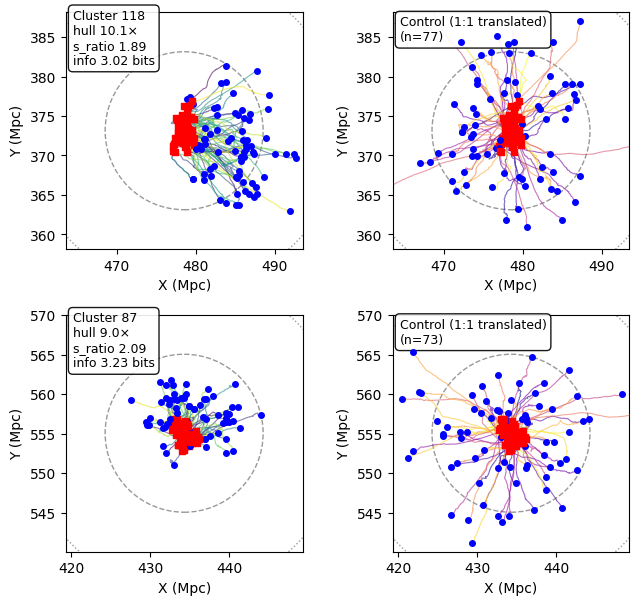

In [23]:
# Classic (collapsed controls)
plot_constrained_vs_control_comparison(
    cluster_ids=[118, 87],
    config=config,
    trace_filename=trace_filename,
    mass_tolerance_dex=0.1,
    target_snapshot=10,
)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from backend.analysis import analyze_volume_ratios_batch

def plot_localization_metrics_vs_mass(clusters, config, trace_filename, 
                                      min_cluster_size=40,
                                      mass_tolerance_dex=0.1,
                                      target_snapshot=10):
    """
    Analysis + plotting of localization metrics vs mean M200 mass.

    Plots (vs mass):
      (a) legacy convex-hull volume ratio (control / constrained)
      (b) dimensionless scatter ratio s_ctrl / s_data  [R_L-normalized]
      (c) information gain (bits) = 0.5 * log2(det(Sc)/det(Sd))

    Returns:
      cluster_masses, legacy_volume_ratios, s_ratios, info_gain_bits, cluster_ids
    """
    (cluster_masses,
     legacy_volume_ratios,
     s_ratios,
     info_gain_bits,
     cluster_ids,
     distances) = analyze_volume_ratios_batch(
        clusters=clusters,
        config=config,
        trace_filename=trace_filename,
        min_cluster_size=min_cluster_size,
        mass_tolerance_dex=mass_tolerance_dex,
        target_snapshot=target_snapshot
    )

    # Guard
    if cluster_masses.size == 0:
        print("No data to plot")
        return (cluster_masses, legacy_volume_ratios, s_ratios, info_gain_bits, cluster_ids)

    # Common binning
    mass_bins = np.logspace(np.log10(cluster_masses.min()),
                            np.log10(cluster_masses.max()), 8)
    bin_indices = np.digitize(cluster_masses, mass_bins)

    def _binstats(y):
        meds, p25s, p75s, centers = [], [], [], []
        for i in range(1, len(mass_bins)):
            msk = (bin_indices == i) & np.isfinite(y)
            if np.sum(msk) >= 2:
                vals = y[msk]
                meds.append(np.median(vals))
                p25s.append(np.percentile(vals, 25))
                p75s.append(np.percentile(vals, 75))
                centers.append(np.sqrt(mass_bins[i-1] * mass_bins[i]))
        if len(centers) == 0:
            return None
        return (np.array(centers), np.array(meds), np.array(p25s), np.array(p75s))

    fig, axes = plt.subplots(1, 3, figsize=(9.5, 3.4), constrained_layout=True)

    # (a) legacy convex-hull volume ratio
    ax = axes[0]
    ax.scatter(cluster_masses, legacy_volume_ratios, alpha=0.6, s=22,
               color='lightblue', edgecolors='steelblue', linewidth=0.4, zorder=1)
    stats = _binstats(legacy_volume_ratios)
    if stats is not None:
        xc, med, p25, p75 = stats
        ax.plot(xc, med, '-o', color='red', linewidth=1.8, markersize=5, zorder=3, label='Median')
        ax.fill_between(xc, p25, p75, color='red', alpha=0.25, zorder=2, label='25–75%')
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel('Mean Cluster $M_{200}$')
    ax.set_ylabel('Hull volume ratio\n(Control / Constrained)')
    ax.axhline(1.0, color='k', linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=8)

    # (b) dimensionless scatter ratio
    ax = axes[1]
    ax.scatter(cluster_masses, s_ratios, alpha=0.6, s=22,
               color='lightblue', edgecolors='steelblue', linewidth=0.4, zorder=1)
    stats = _binstats(s_ratios)
    if stats is not None:
        xc, med, p25, p75 = stats
        ax.plot(xc, med, '-o', color='red', linewidth=1.8, markersize=5, zorder=3, label='Median')
        ax.fill_between(xc, p25, p75, color='red', alpha=0.25, zorder=2, label='25–75%')
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel('Mean Cluster $M_{200}$')
    ax.set_ylabel('Dimensionless scatter ratio\n$s_{\\rm ctrl}/s_{\\rm data}$')
    ax.axhline(1.0, color='k', linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=8)

    # (c) information gain in bits
    ax = axes[2]
    ax.scatter(cluster_masses, info_gain_bits, alpha=0.6, s=22,
               color='lightblue', edgecolors='steelblue', linewidth=0.4, zorder=1)
    stats = _binstats(info_gain_bits)
    if stats is not None:
        xc, med, p25, p75 = stats
        ax.plot(xc, med, '-o', color='red', linewidth=1.8, markersize=5, zorder=3, label='Median')
        ax.fill_between(xc, p25, p75, color='red', alpha=0.25, zorder=2, label='25–75%')
    ax.set_xscale('log')
    ax.set_xlabel('Mean Cluster $M_{200}$')
    ax.set_ylabel('Information gain (bits)')
    ax.axhline(0.0, color='k', linestyle='--', alpha=0.5)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=8)

    plt.show()

    # Print quick summaries
    def _safe_geom_mean(x):
        x = x[np.isfinite(x) & (x > 0)]
        return np.exp(np.mean(np.log(x))) if x.size else np.nan

    print("\nLocalization Metrics Summary:")
    print(f"  N clusters: {cluster_masses.size}")
    if np.isfinite(legacy_volume_ratios).any():
        print(f"  Hull ratio (ctrl/data): median={np.nanmedian(legacy_volume_ratios):.2f}×, "
              f"geomean={_safe_geom_mean(legacy_volume_ratios):.2f}×, "
              f"range=({np.nanmin(legacy_volume_ratios):.2f}×–{np.nanmax(legacy_volume_ratios):.2f}×)")
    if np.isfinite(s_ratios).any():
        print(f"  s-ratio (ctrl/data):   median={np.nanmedian(s_ratios):.2f}, "
              f"geomean={_safe_geom_mean(s_ratios):.2f}, "
              f"range=({np.nanmin(s_ratios):.2f}–{np.nanmax(s_ratios):.2f})")
    if np.isfinite(info_gain_bits).any():
        print(f"  Info gain (bits):      median={np.nanmedian(info_gain_bits):.2f}, "
              f"mean={np.nanmean(info_gain_bits):.2f}, "
              f"range=({np.nanmin(info_gain_bits):.2f}–{np.nanmax(info_gain_bits):.2f})")

    return (cluster_masses, legacy_volume_ratios, s_ratios, info_gain_bits, cluster_ids)

Loading control index...
Loading constrained traces for 225 clusters...
Processing control matches...
Computing localization metrics (covariance + convex hull)...


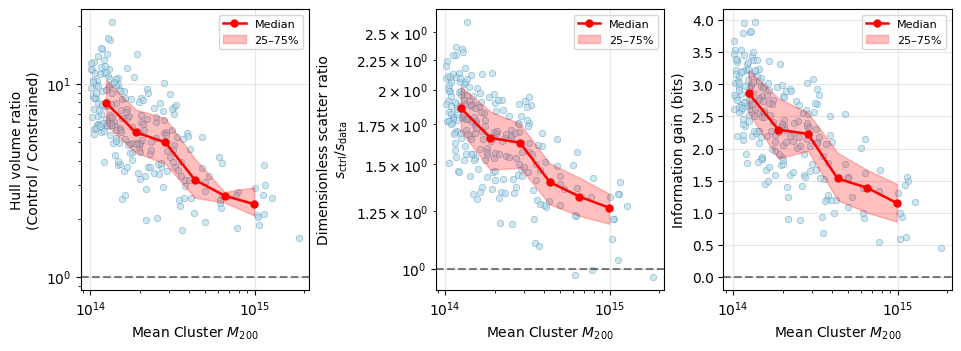


Localization Metrics Summary:
  N clusters: 223
  Hull ratio (ctrl/data): median=5.88×, geomean=5.70×, range=(1.59×–20.86×)
  s-ratio (ctrl/data):   median=1.69, geomean=1.66, range=(0.97–2.60)
  Info gain (bits):      median=2.42, mean=2.36, range=(0.45–3.97)


(array([2.32920556e+14, 1.24006351e+14, 1.84237420e+14, 3.23942472e+14,
        1.39168768e+14, 4.78001607e+14, 3.77572454e+14, 2.69060105e+14,
        2.81473517e+14, 1.56081410e+14, 2.22068231e+14, 2.81902326e+14,
        1.47720669e+14, 1.26894180e+14, 1.06014188e+15, 3.89254933e+14,
        2.17069375e+14, 3.21900853e+14, 2.75883869e+14, 3.72946271e+14,
        1.48054368e+14, 1.84250419e+15, 1.98500168e+14, 1.50845526e+14,
        1.49936872e+14, 6.23809170e+14, 7.74983630e+14, 2.75138910e+14,
        1.16990027e+14, 2.02069135e+14, 1.02081902e+14, 1.30296406e+14,
        1.55172790e+14, 1.33327504e+14, 2.02787082e+14, 1.93230763e+14,
        1.11563495e+14, 6.33244677e+14, 1.25791279e+14, 3.56027522e+14,
        1.62798236e+14, 1.66038537e+14, 1.24648222e+14, 1.27705182e+14,
        1.31285440e+14, 1.50709396e+14, 2.56590054e+14, 2.89988172e+14,
        1.27344197e+15, 1.15631920e+14, 1.49672463e+14, 1.54674087e+14,
        5.00394392e+14, 3.11980317e+14, 1.25534369e+14, 2.013432

In [14]:
plot_localization_metrics_vs_mass(
    clusters=clusters,
    config=config,
    trace_filename=trace_filename,
    min_cluster_size=40,
    mass_tolerance_dex=0.1,
    target_snapshot=10
)

# Mass distributions

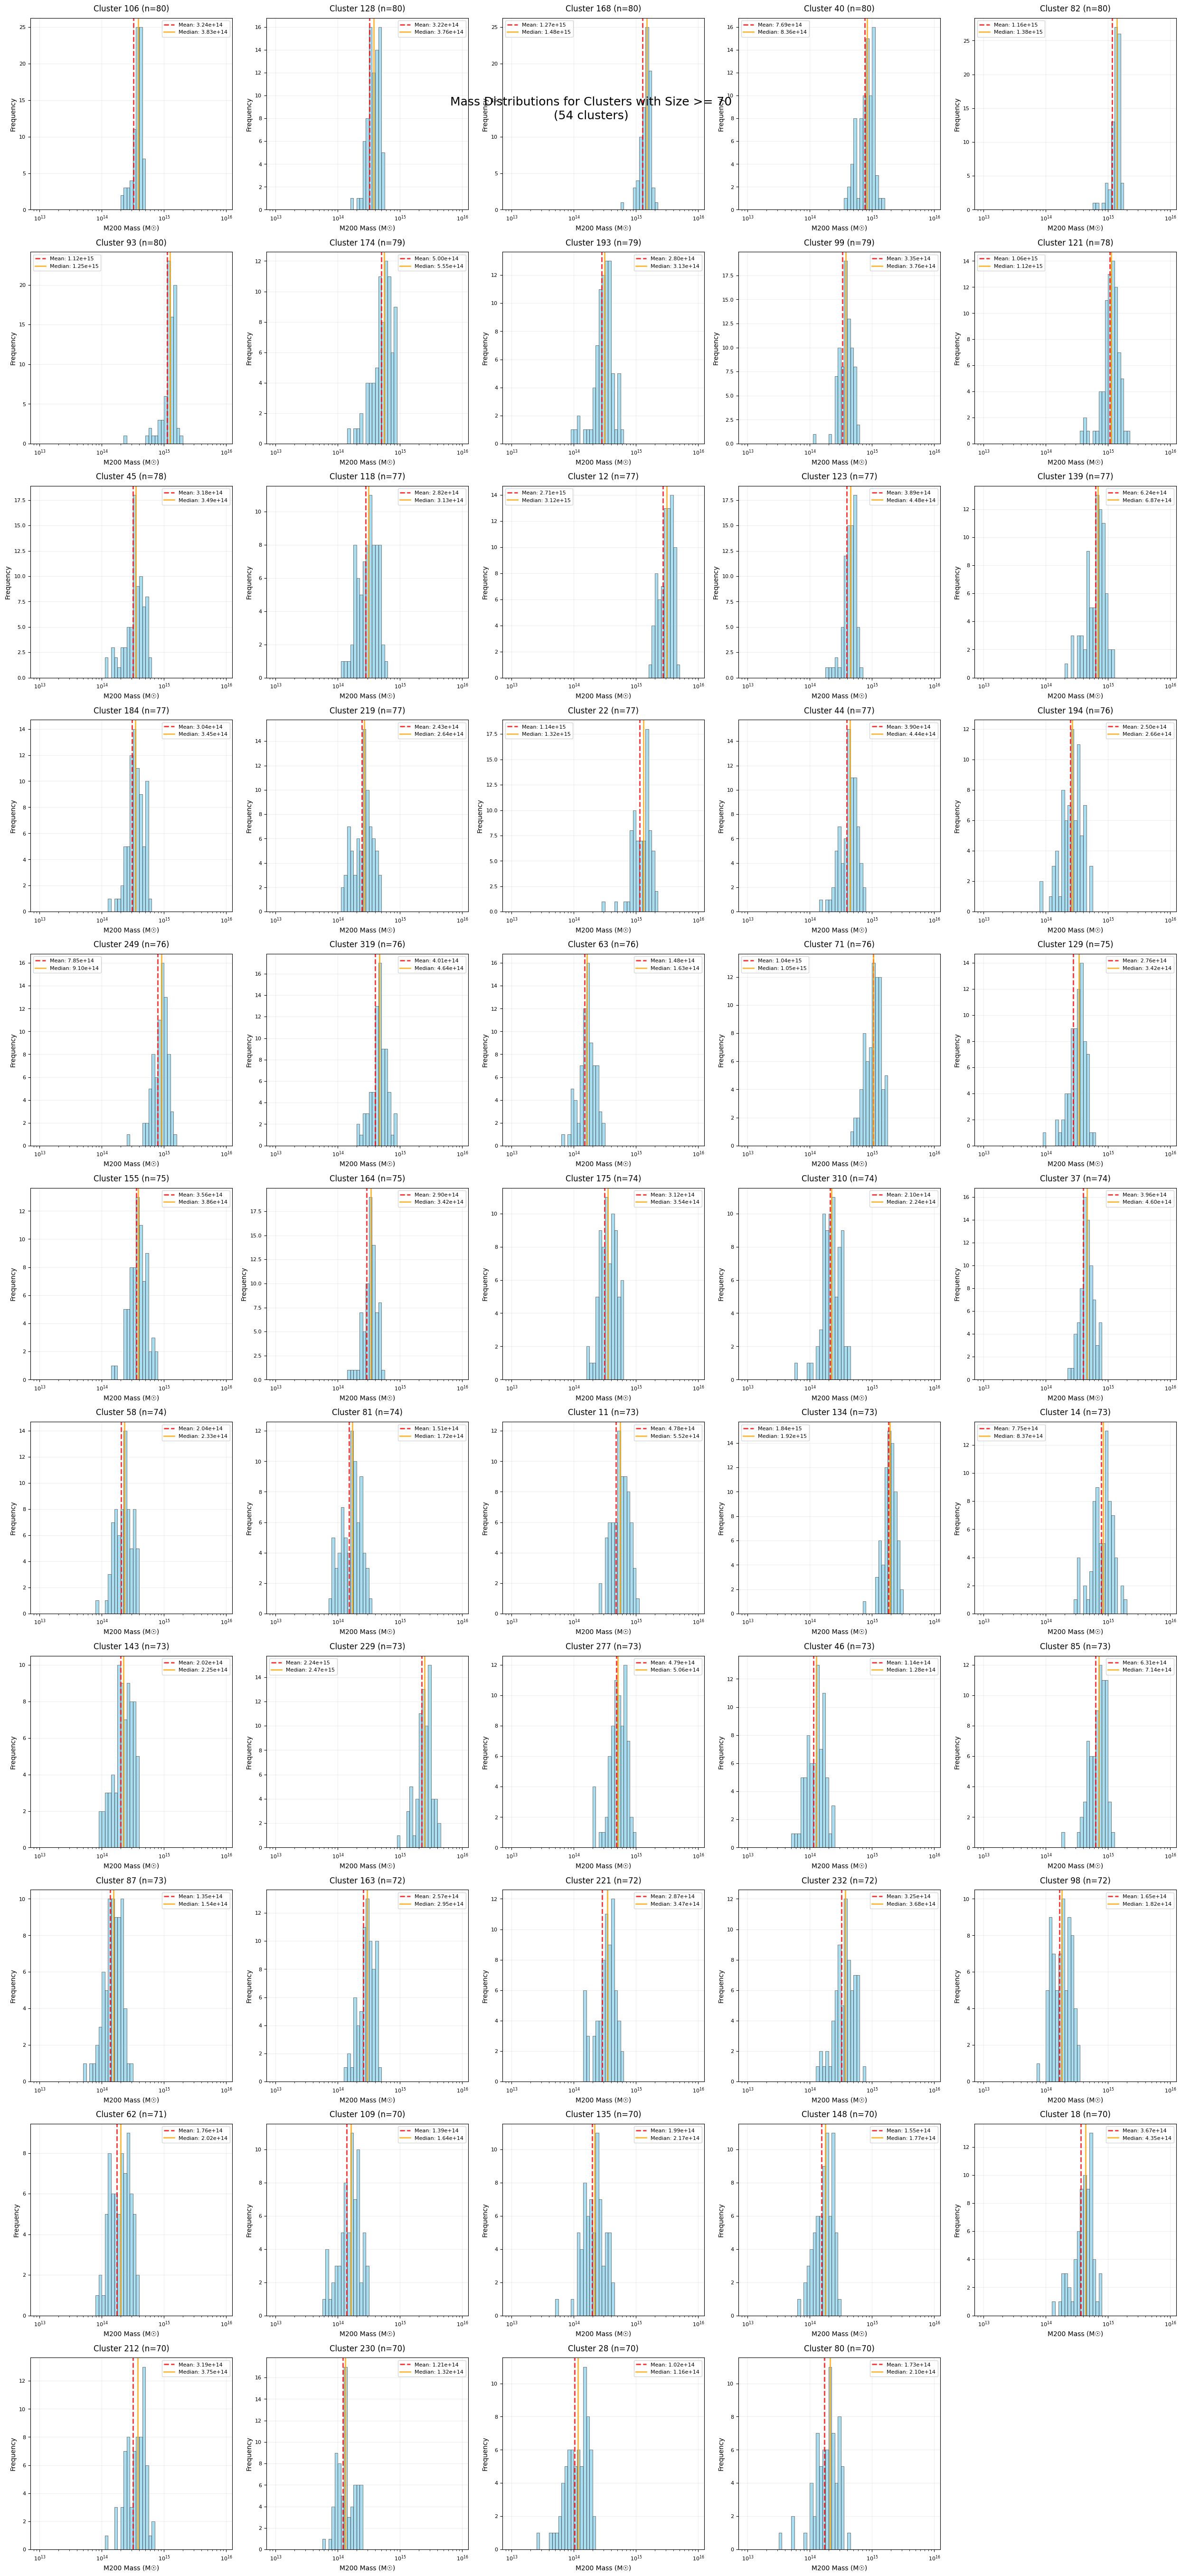

In [19]:
# Cell: Mass Distributions for Clusters Above Size Threshold (5xN Grid)
if clusters_available and len(clusters) > 0:
    # Set cluster size threshold
    cluster_size_threshold = 70  # Adjustable parameter
    
    # Filter clusters by size
    large_clusters = [cluster for cluster in clusters if cluster['cluster_size'] >= cluster_size_threshold]
    
    if len(large_clusters) == 0:
        print(f"No clusters found with size >= {cluster_size_threshold}")
    else:
        # Calculate grid dimensions (5 columns, as many rows as needed)
        n_cols = 5
        n_rows = (len(large_clusters) + n_cols - 1) // n_cols  # Ceiling division
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
        
        # Handle case where there's only one row
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        axes = axes.flatten()
        
        # Sort by cluster size descending
        large_clusters.sort(key=lambda c: c['cluster_size'], reverse=True)
        
        for plot_idx in range(len(large_clusters)):
            cluster = large_clusters[plot_idx]
            ax = axes[plot_idx]
            plot_cluster_mass_distribution(cluster['cluster_id'], ax=ax)
        
        # Hide unused subplots
        for plot_idx in range(len(large_clusters), n_rows * n_cols):
            axes[plot_idx].set_visible(False)
        
        plt.suptitle(f'Mass Distributions for Clusters with Size >= {cluster_size_threshold}\n({len(large_clusters)} clusters)', fontsize=18, y=0.95)
        plt.tight_layout()
        #plt.subplots_adjust(top=0.92)
        plt.show()

# Inspect individual clusters

Selected cluster analysis:
  Cluster ID: 28
  Size: 70 members
  Center: [370.4, 522.0, 589.2]
  Mean m200 mass: 1.02e+14
  Mass m200 std: 3.36e+13


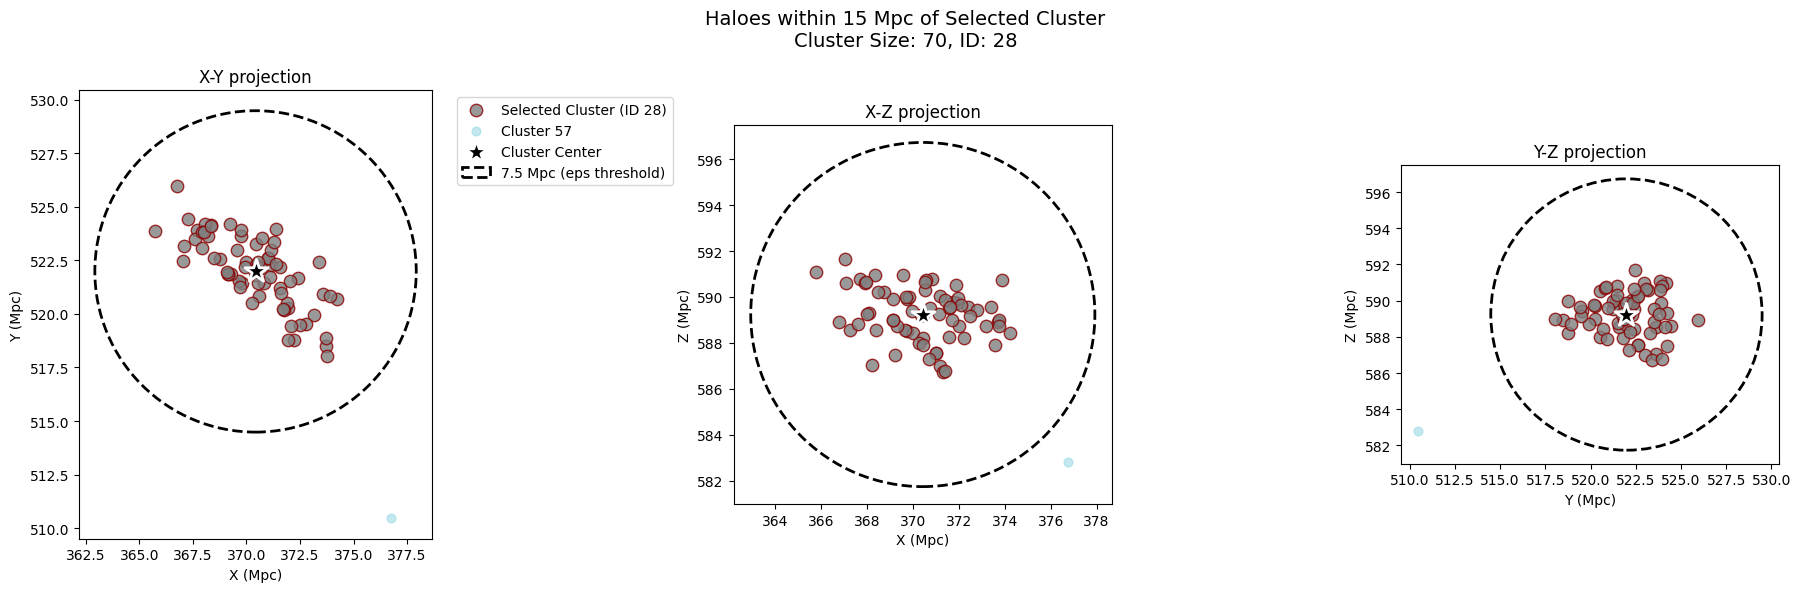

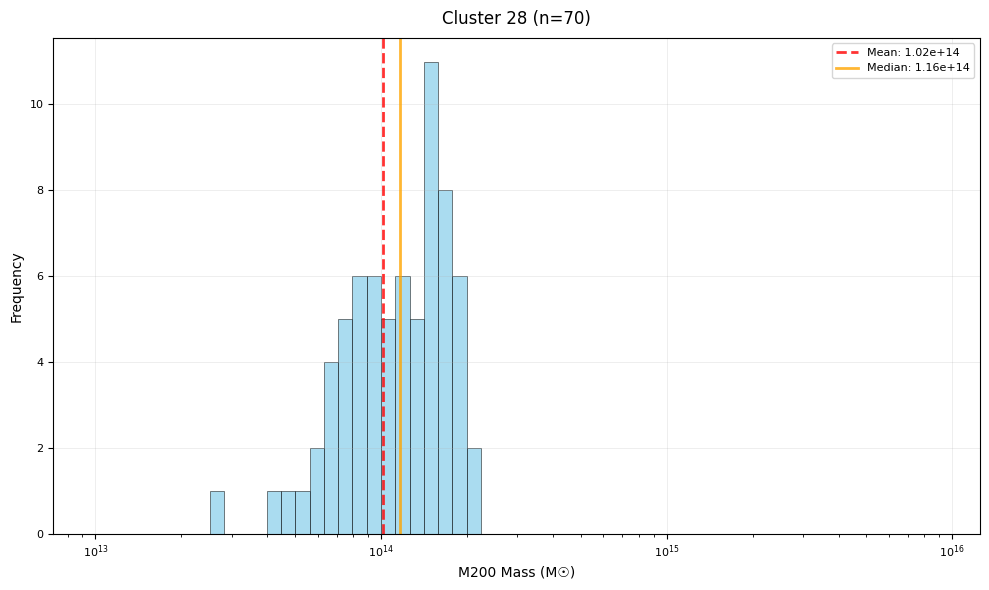

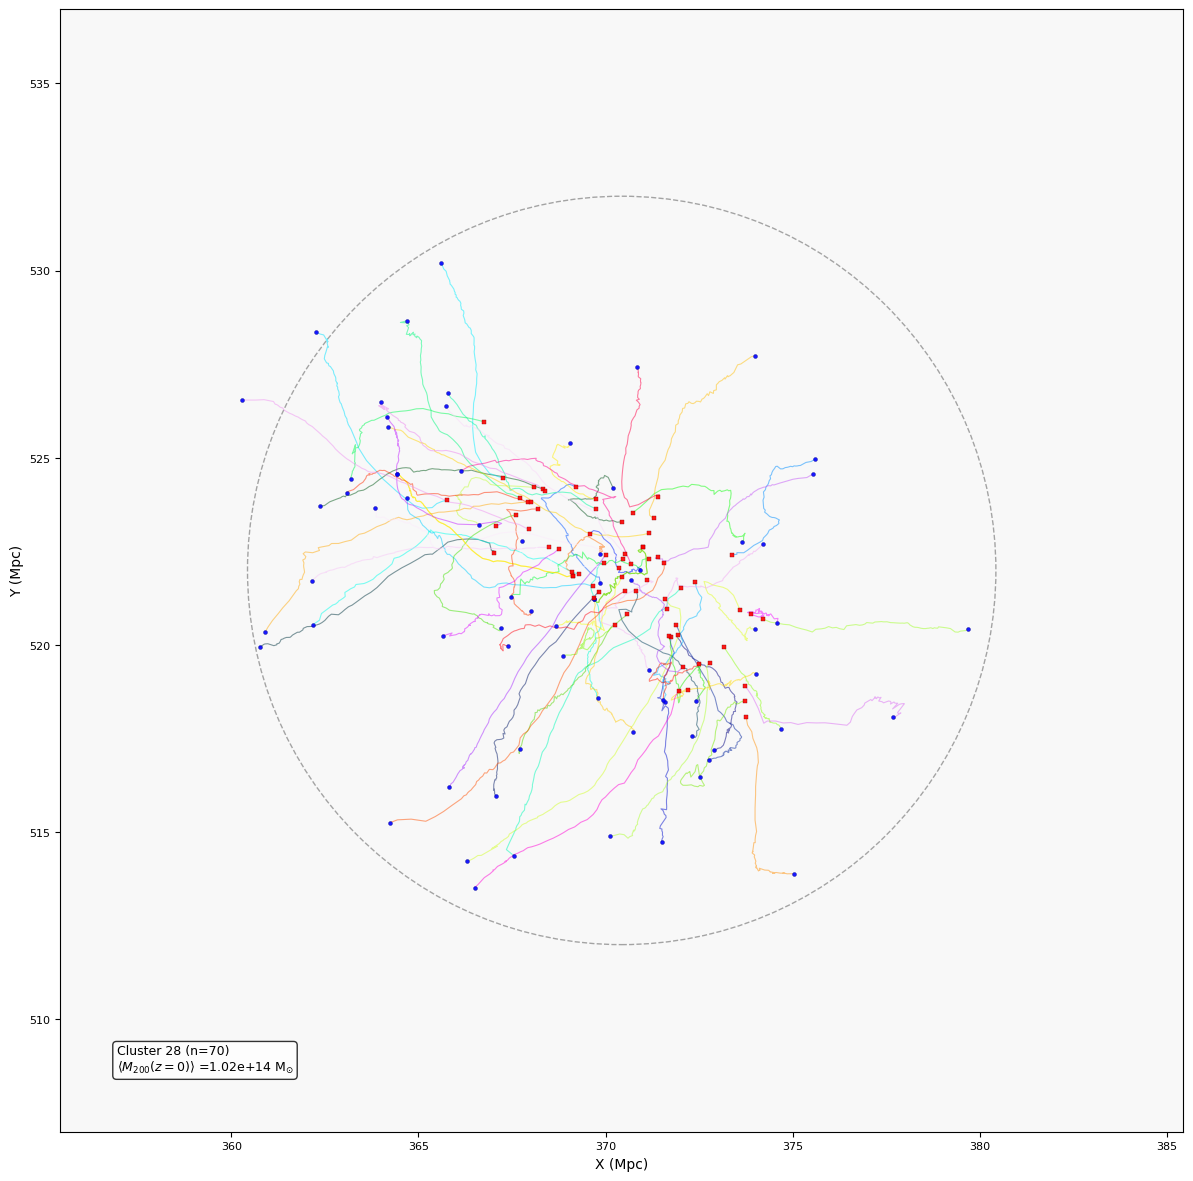

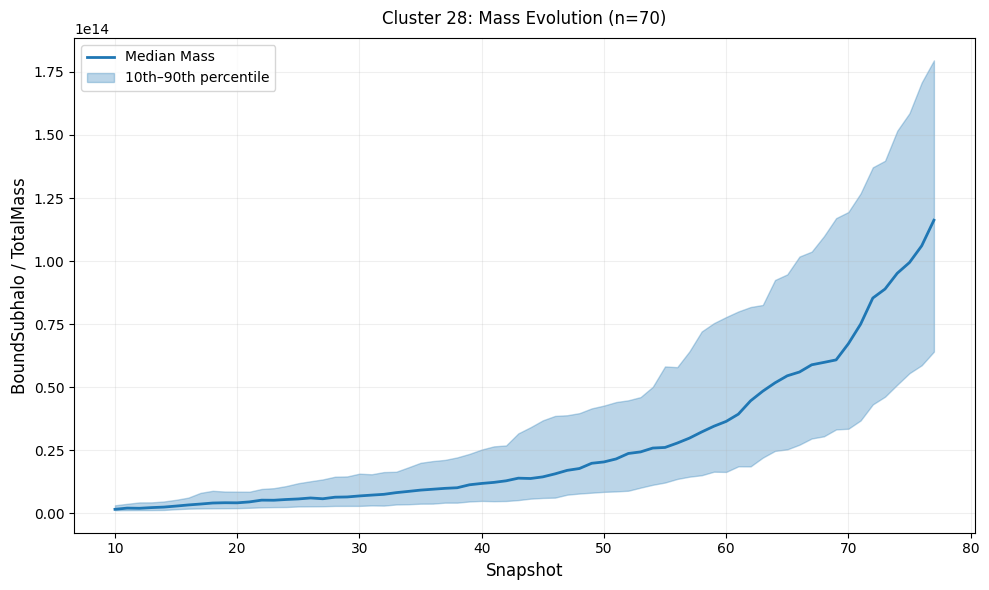

In [18]:
cluster_id = 28
plot_cluster_diagnostic(cluster_id=cluster_id)
plot_cluster_mass_distribution(cluster_id=cluster_id)
_ = plot_cluster_trajectory(cluster_id=cluster_id)
plot_cluster_mass_evolution(cluster_id=cluster_id)

In [ ]:
plot_cluster_diagnostic(coordinates=[460, 482, 470])
plot_cluster_diagnostic(coordinates=[550,522,540])

# Save median properties

In [ ]:
# Cell: Export Simplified Cluster Data
import h5py
import numpy as np
import os

# Configuration variables
min_cluster_size = 30  # Modify this threshold as needed
output_filename = "simplified_clusters.h5"  # Modify filename as needed

if clusters_available and len(clusters) > 0:
    # Filter clusters by size threshold
    filtered_clusters = [cluster for cluster in clusters if cluster['cluster_size'] >= min_cluster_size]
    
    if len(filtered_clusters) == 0:
        print(f"No clusters found with size >= {min_cluster_size}")
    else:
        print(f"Processing {len(filtered_clusters)} clusters with size >= {min_cluster_size}")
        
        # Get all property keys from first cluster
        property_keys = list(filtered_clusters[0]['member_data'].keys())
        
        # Initialize storage for median values
        cluster_ids = []
        cluster_sizes = []
        median_properties = {}
        
        # Initialize median property arrays
        for key in property_keys:
            sample_data = filtered_clusters[0]['member_data'][key]
            if len(sample_data.shape) == 1:
                # 1D property
                median_properties[key] = []
            elif len(sample_data.shape) == 2 and sample_data.shape[1] == 3:
                # 3D vector property
                median_properties[key] = []
            else:
                # Other multi-dimensional properties
                median_properties[key] = []
        
        # Calculate medians for each cluster
        for cluster in filtered_clusters:
            cluster_ids.append(cluster['cluster_id'])
            cluster_sizes.append(cluster['cluster_size'])
            
            for key in property_keys:
                data = cluster['member_data'][key]
                
                if len(data.shape) == 1:
                    # 1D property - simple median
                    median_val = np.nanmedian(data)
                    median_properties[key].append(median_val)
                elif len(data.shape) == 2 and data.shape[1] == 3:
                    # 3D vector - median per component
                    median_vec = np.nanmedian(data, axis=0)
                    median_properties[key].append(median_vec)
                else:
                    # Other shapes - median along first axis
                    median_val = np.nanmedian(data, axis=0)
                    median_properties[key].append(median_val)
        
        # Convert lists to arrays
        cluster_ids = np.array(cluster_ids)
        cluster_sizes = np.array(cluster_sizes)
        for key in property_keys:
            median_properties[key] = np.array(median_properties[key])
        
        # Save to HDF5
        output_path = os.path.join(config.global_config.output_dir, output_filename)
        
        with h5py.File(output_path, 'w') as f:
            # Metadata
            meta_grp = f.create_group('metadata')
            meta_grp.attrs['threshold_size'] = min_cluster_size
            meta_grp.attrs['n_clusters'] = len(filtered_clusters)
            meta_grp.attrs['source_file'] = 'clusters.h5'
            meta_grp.attrs['total_properties'] = len(property_keys)
            
            # Copy original metadata if available
            if 'cluster_metadata' in locals():
                for key, value in cluster_metadata.items():
                    if isinstance(value, (int, float, str)):
                        meta_grp.attrs[f'original_{key}'] = value
                    elif isinstance(value, (list, np.ndarray)):
                        meta_grp.attrs[f'original_{key}'] = np.array(value)
            
            # Cluster data
            clusters_grp = f.create_group('clusters')
            clusters_grp.create_dataset('cluster_ids', data=cluster_ids)
            clusters_grp.create_dataset('cluster_sizes', data=cluster_sizes)
            
            # Median properties
            median_grp = clusters_grp.create_group('median_properties')
            for key, data in median_properties.items():
                # Convert property name to HDF5-safe format
                dataset_name = key.replace('/', '_')
                median_grp.create_dataset(dataset_name, data=data)
        
        print(f"Saved simplified cluster data to: {output_path}")
        print(f"Properties included: {len(property_keys)}")
        print(f"Sample properties: {property_keys[:5]}{'...' if len(property_keys) > 5 else ''}")
        
        # Summary statistics
        print(f"\nSummary:")
        print(f"  Clusters processed: {len(filtered_clusters)}")
        print(f"  Size range: {np.min(cluster_sizes)} - {np.max(cluster_sizes)}")
        print(f"  Mean cluster size: {np.mean(cluster_sizes):.1f}")
        print(f"  File size: {os.path.getsize(output_path) / 1024**2:.2f} MB")

else:
    print("No cluster data available. Run Mode 1 first.")

# Plots for paper

## Looking at individual halo groupings

This demonstrates that the clustering algorithm and choice of hyperparameters are suitable, that distinct halo groupings are identified as suitable clusters.

In [ ]:
# Cell: Multi-Cluster Diagnostic Plot
def plot_multi_cluster_diagnostic(cluster_ids, window_size=15.0):
  if not clusters_available or len(clusters) == 0:
      print("No clusters available for diagnostic plot")
      return
  
  # Find target clusters
  target_clusters = []
  for cluster_id in cluster_ids:
      target_cluster = None
      for cluster in clusters:
          if cluster['cluster_id'] == cluster_id:
              target_cluster = cluster
              break
      if target_cluster is None:
          print(f"Cluster ID {cluster_id} not found")
          return
      target_clusters.append(target_cluster)
  
  with plt.style.context(get_mplstyle_path(mnras_style)):
      fig, axes = plt.subplots(len(cluster_ids), 3, figsize=(6.5, 6.5))
      if len(cluster_ids) == 1:
          axes = axes.reshape(1, -1)
      
      projections = [
          (0, 1, 'X', 'Y'),
          (0, 2, 'X', 'Z'), 
          (1, 2, 'Y', 'Z')
      ]
      
      symbols = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']
      
      # Collect all unique cluster IDs across all rows (only those with centroids in windows)
      all_unique_cluster_ids = set()
      for target_cluster in target_clusters:
          target_cluster_center = target_cluster['mean_position']
          
          # Find clusters whose centroids are within the window
          for cluster in clusters:
              cluster_center = cluster['mean_position']
              distance_to_target = np.linalg.norm(cluster_center - target_cluster_center)
              if distance_to_target <= window_size:
                  all_unique_cluster_ids.add(cluster['cluster_id'])
      
      # Create global color and symbol map for all unique cluster IDs
      all_unique_cluster_ids = sorted(list(all_unique_cluster_ids))
      colors = plt.cm.tab10(np.linspace(0, 1, len(all_unique_cluster_ids)))
      global_color_map = {cluster_id: colors[i] for i, cluster_id in enumerate(all_unique_cluster_ids)}
      global_symbol_map = {cluster_id: symbols[i % len(symbols)] for i, cluster_id in enumerate(all_unique_cluster_ids)}
      
      for row_idx, target_cluster in enumerate(target_clusters):
          target_cluster_center = target_cluster['mean_position']
          target_cluster_id = target_cluster['cluster_id']
          
          # Find clusters whose centroids are within the window
          clusters_in_window = []
          for cluster in clusters:
              cluster_center = cluster['mean_position']
              distance_to_target = np.linalg.norm(cluster_center - target_cluster_center)
              if distance_to_target <= window_size:
                  clusters_in_window.append(cluster)
          
          # Only plot members from clusters whose centroids are in the window
          nearby_positions = []
          nearby_cluster_labels = []
          
          for cluster in clusters_in_window:
              positions = cluster['member_data']['BoundSubhalo/CentreOfMass']
              cluster_id_val = cluster['cluster_id']
              nearby_positions.extend(positions)
              nearby_cluster_labels.extend([cluster_id_val] * len(positions))
          
          nearby_positions = np.array(nearby_positions)
          nearby_cluster_labels = np.array(nearby_cluster_labels)
          
          # Calculate optimized axis limits for this row
          if len(nearby_positions) > 0:
              min_pos = np.min(nearby_positions, axis=0)
              max_pos = np.max(nearby_positions, axis=0)
              ranges = max_pos - min_pos
              centers = (min_pos + max_pos) / 2
              max_range = np.max(ranges)
              padding = max_range * 0.05
          else:
              centers = target_cluster_center
              max_range = 10.0
              padding = 0.5
          
          unique_labels = np.unique(nearby_cluster_labels)
          
          for proj_idx, (dim1, dim2, label1, label2) in enumerate(projections):
              ax = axes[row_idx, proj_idx]
              
              legend_handles = []
              
              for label in unique_labels:
                  mask = nearby_cluster_labels == label
                  color = global_color_map[label]
                  symbol = global_symbol_map[label]
                  scatter = ax.scatter(nearby_positions[mask, dim1], nearby_positions[mask, dim2], 
                            c=[color], s=10, alpha=0.6, marker=symbol)
                  
                  if proj_idx == 2:  # Only create legend entries for first column
                      legend_handles.append(plt.Line2D([0], [0], marker=symbol, color='w', 
                                                     markerfacecolor=color, markersize=8, 
                                                     label=f'Cluster {label}', alpha=0.6))
              
              # Plot cluster centroids and annotations
              for cluster in clusters_in_window:
                  cluster_center = cluster['mean_position']
                  cluster_id_val = cluster['cluster_id']
                  color = global_color_map[cluster_id_val]
                  
                  # Mark centroid
                  ax.scatter(cluster_center[dim1], cluster_center[dim2], 
                            c='red', s=100, marker='*', edgecolors='black', linewidth=0.5)
                  
                  # Add position std circle around centroid
                  position_std = np.linalg.norm(cluster['position_std'])
                  circle = plt.Circle((cluster_center[dim1], cluster_center[dim2]), 
                                     position_std, fill=False, color=color, linestyle='-', linewidth=1, alpha=0.7)
                  ax.add_patch(circle)

              if row_idx == len(cluster_ids) - 1:
                  ax.set_xlabel(f'{label1} (Mpc)')
              ax.set_ylabel(f'{label2} (Mpc)')
              ax.set_aspect('equal')
              
              # Set optimized square axis limits
              center_2d = centers[[dim1, dim2]]
              half_range = max_range / 2 + padding
              ax.set_xlim(center_2d[0] - half_range, center_2d[0] + half_range)
              ax.set_ylim(center_2d[1] - half_range, center_2d[1] + half_range)
              
              # Add legend only to first column
              if proj_idx == 2 and legend_handles:
                  loc = "lower left" if row_idx == 1 else "upper left"
                  ax.legend(handles=legend_handles, loc=loc, fontsize=8)
              
              # Add cluster info text in bottom right of third column
              if proj_idx == 2 and False:
                  target_color = global_color_map[target_cluster_id]
                  info_text = f"ID: {target_cluster_id}\n"
                  info_text += f"Mass: {target_cluster['mean_mass']:.2e} \n"
                  info_text += f"Members: {target_cluster['cluster_size']}"

                  xtext = 0.53 if row_idx == 1 else 0.96
                  ytext = 0.73 if row_idx == 1 else 0.04
                  
                  ax.text(xtext, ytext, info_text, 
                         transform=ax.transAxes, 
                         fontsize=9, 
                         color=target_color, 
                         fontweight='bold',
                         ha='right', va='bottom',
                         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
      
      plt.tight_layout(pad=0.1)
      plt.subplots_adjust(hspace=-0.15, wspace=0.3)
      plt.savefig("./plots/example_halo_groupings.pdf")
      plt.show()

# Example usage
cluster_ids_to_plot = [163,98,45]
plot_multi_cluster_diagnostic(cluster_ids_to_plot, window_size=20)

In [ ]:
# Cell: Cluster Position Std vs Mean Mass with Custom Size Bins
def plot_position_std_vs_mass(size_bin_edges):
   if not clusters_available or len(clusters) == 0:
       print("No clusters available")
       return
   
   cluster_masses = np.array([cluster['mean_m200_mass'] for cluster in clusters])
   position_stds = np.array([np.linalg.norm(cluster['position_std']) for cluster in clusters])
   cluster_sizes = np.array([cluster['cluster_size'] for cluster in clusters])
   
   # Create masks for size bins using bin edges
   masks = []
   labels = []
   for i in range(len(size_bin_edges) - 1):
       mask = (cluster_sizes >= size_bin_edges[i]) & (cluster_sizes < size_bin_edges[i+1])
       labels.append(f'{size_bin_edges[i]}-{size_bin_edges[i+1]}')
       masks.append(mask)
   
   colors = plt.cm.Set1(np.linspace(0, 1, len(masks)))

   with plt.style.context(get_mplstyle_path(mnras_style)):
       fig, ax = plt.subplots(figsize=(3.15, 2.5))
       
       # Create log-spaced mass bins
       mass_bins = np.logspace(np.log10(cluster_masses.min()), np.log10(cluster_masses.max()), 15)
       
       for i, (mask, label, color) in enumerate(zip(masks, labels, colors)):
           if np.sum(mask) == 0:
               continue
               
           masses_subset = cluster_masses[mask]
           stds_subset = position_stds[mask]
           
           # Bin the data
           bin_indices = np.digitize(masses_subset, mass_bins)
           
           medians = []
           p25 = []
           p75 = []
           bin_centers = []
           
           for j in range(1, len(mass_bins)):
               bin_mask = bin_indices == j
               if np.sum(bin_mask) >= 3:  # Need at least 3 points for statistics
                   bin_stds = stds_subset[bin_mask]
                   medians.append(np.median(bin_stds))
                   p25.append(np.percentile(bin_stds, 25))
                   p75.append(np.percentile(bin_stds, 75))
                   bin_centers.append(np.sqrt(mass_bins[j-1] * mass_bins[j]))
           
           if len(medians) > 0:
               bin_centers = np.array(bin_centers)
               medians = np.array(medians)
               p25 = np.array(p25)
               p75 = np.array(p75)
               
               ax.plot(bin_centers, medians, '-o', color=color, label=label, linewidth=2, markersize=6)
               ax.fill_between(bin_centers, p25, p75, color=color, alpha=0.3)
       
       ax.set_xlabel('Mean Halo Mass in Grouping [M$_{\odot}$]')
       ax.set_ylabel('Position STD (Mpc)')
       ax.set_xscale('log')
       ax.grid(True, alpha=0.3)
       ax.legend(title="Group members")
       
       plt.tight_layout(pad=0.1)
       plt.savefig("./plots/position_std_vs_mass.pdf")
       plt.show()

# Example usage
size_bin_edges = [40, 60, 80]
plot_position_std_vs_mass(size_bin_edges)